In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Load the dataset

First, input the name you gave to the inverted glacier file

In [2]:
# INPUT THE NAME HERE
name = 'Aletsch'

# Load the data
glacier = xr.open_dataset(f'./Datacubes/{name}/{name}.nc')

# Calculate the temporal average of each pixel
avg_vels = np.nanmean(np.sqrt(glacier.vx.values**2 + glacier.vy.values**2), axis = 0)

/tmp/ipykernel_2230/2497932850.py:7: RuntimeWarning: Mean of empty slice
  avg_vels = np.nanmean(np.sqrt(glacier.vx.values**2 + glacier.vy.values**2), axis = 0)


#### Calculate the velocity magnitude

In [4]:
# Create a DataArray gathering velocity magnitude from velocity components
da = xr.DataArray(
    np.sqrt(glacier.vx.values**2 + glacier.vy.values**2),
    coords=[glacier.time, glacier.y, glacier.x],
    dims=["time", "y", "x"]
)



#### Calculate the EOFs of the velocity magnitude

In [ ]:
# Calculate the empirical orthogonal functions but fill NaNs with -1
solver = Eof(da.fillna(-1))

#### Plot the EOFs

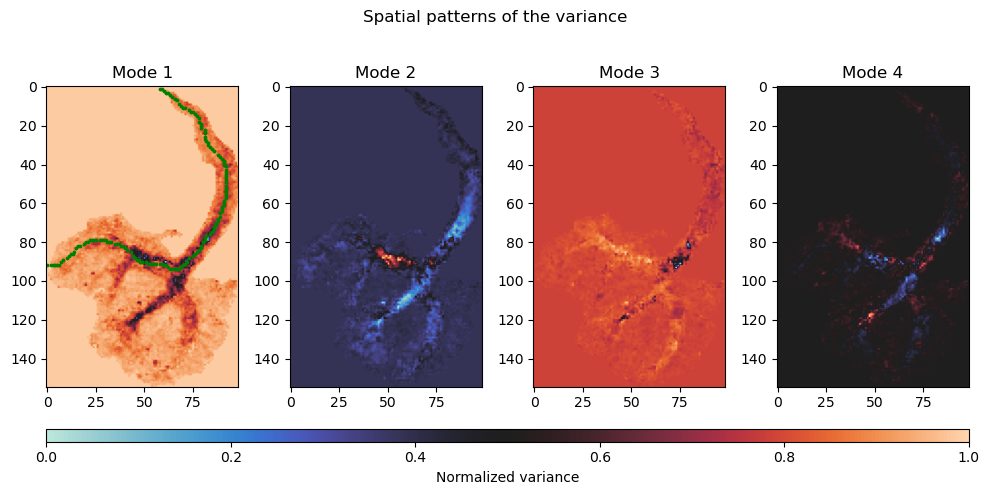

In [5]:


### Figure 1: spatial modes EOFs
fig = plt.figure(figsize=(10, 5)) # Initialize the figure
gs = gridspec.GridSpec(2, 4, height_ratios=[30, 1]) # Divide into 2 so we can fit the colorbar below
plt.suptitle('Spatial patterns of the variance')
eofs = solver.eofsAsCovariance(neofs=4) # Calculate the first 4 spatial modes

# Plot them
for i in range(4):
    ax = plt.subplot(gs[0, i])
    eof = (eofs.values[i] - eofs.values[i].min()) / (eofs.values[i].max() - eofs.values[i].min())
    if i == 0:
        ax.scatter(glacier.x_coords_centerline, glacier.y_coords_centerline, color = 'green', label = 'Centerline', s = 3)
    heatmap = ax.imshow(eof, cmap = 'icefire')
    ax.set_title(f'Mode {i+1}')

cbar_ax = fig.add_subplot(gs[1, :]) # Specify that the colorbar spans the entire figure
cbar = plt.colorbar(heatmap, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Normalized variance')
plt.tight_layout()
plt.show()

# Save the figure in the figs folder
fig.savefig('./figs/Eofs.png')

# Plot another figure explaining the modes variance in time
plt.figure()
n_eig = [i for i in range(1,11)]
plt.scatter(n_eig, solver.varianceFraction()[:10]*100) # Convert to percents
plt.title('Variance explained by principal modes')
plt.ylabel('Percentage of variance [%]')
plt.xlabel('Principal Mode')


### Visualization

First we select the velocities along the centerline, and we calculate the distance between each point

In [4]:
# Import centerline velocities
centerline_vels = np.sqrt((glacier.vx.values[:, glacier.y_coords_centerline.values, glacier.x_coords_centerline.values]**2) + (glacier.vy.values[:, glacier.y_coords_centerline.values, glacier.x_coords_centerline.values]**2))

# Calculate the differences between consecutive points
dy = np.diff(glacier.y.values[glacier.y_coords_centerline.values])
dx = np.diff(glacier.x.values[glacier.x_coords_centerline.values])

# Calculate the distance of each point to the first point of the centerline
distances = np.round(np.cumsum(np.sqrt(dx**2 + dy**2)))
distances = np.int32(np.hstack((np.array([0]), distances)))

# Create a DataFrame with 'time' as the index
df = pd.DataFrame(centerline_vels, index=[str(glacier.time.values[i])[:10] for i in range(len(glacier.time.values))], columns=distances)

### Hovmöller plot

We plot the velocities along the centerline of the glacier. X-axis is the position along the transect [m], Y-axis is time, and the colors represent surface velocities.

**Beware, you might need to run the cell below 2 times to get the Y-axis displayed correctly**

/tmp/ipykernel_219/41101479.py:8: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  f.subplots_adjust(hspace=0.05, wspace=0.05)
/tmp/ipykernel_219/41101479.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


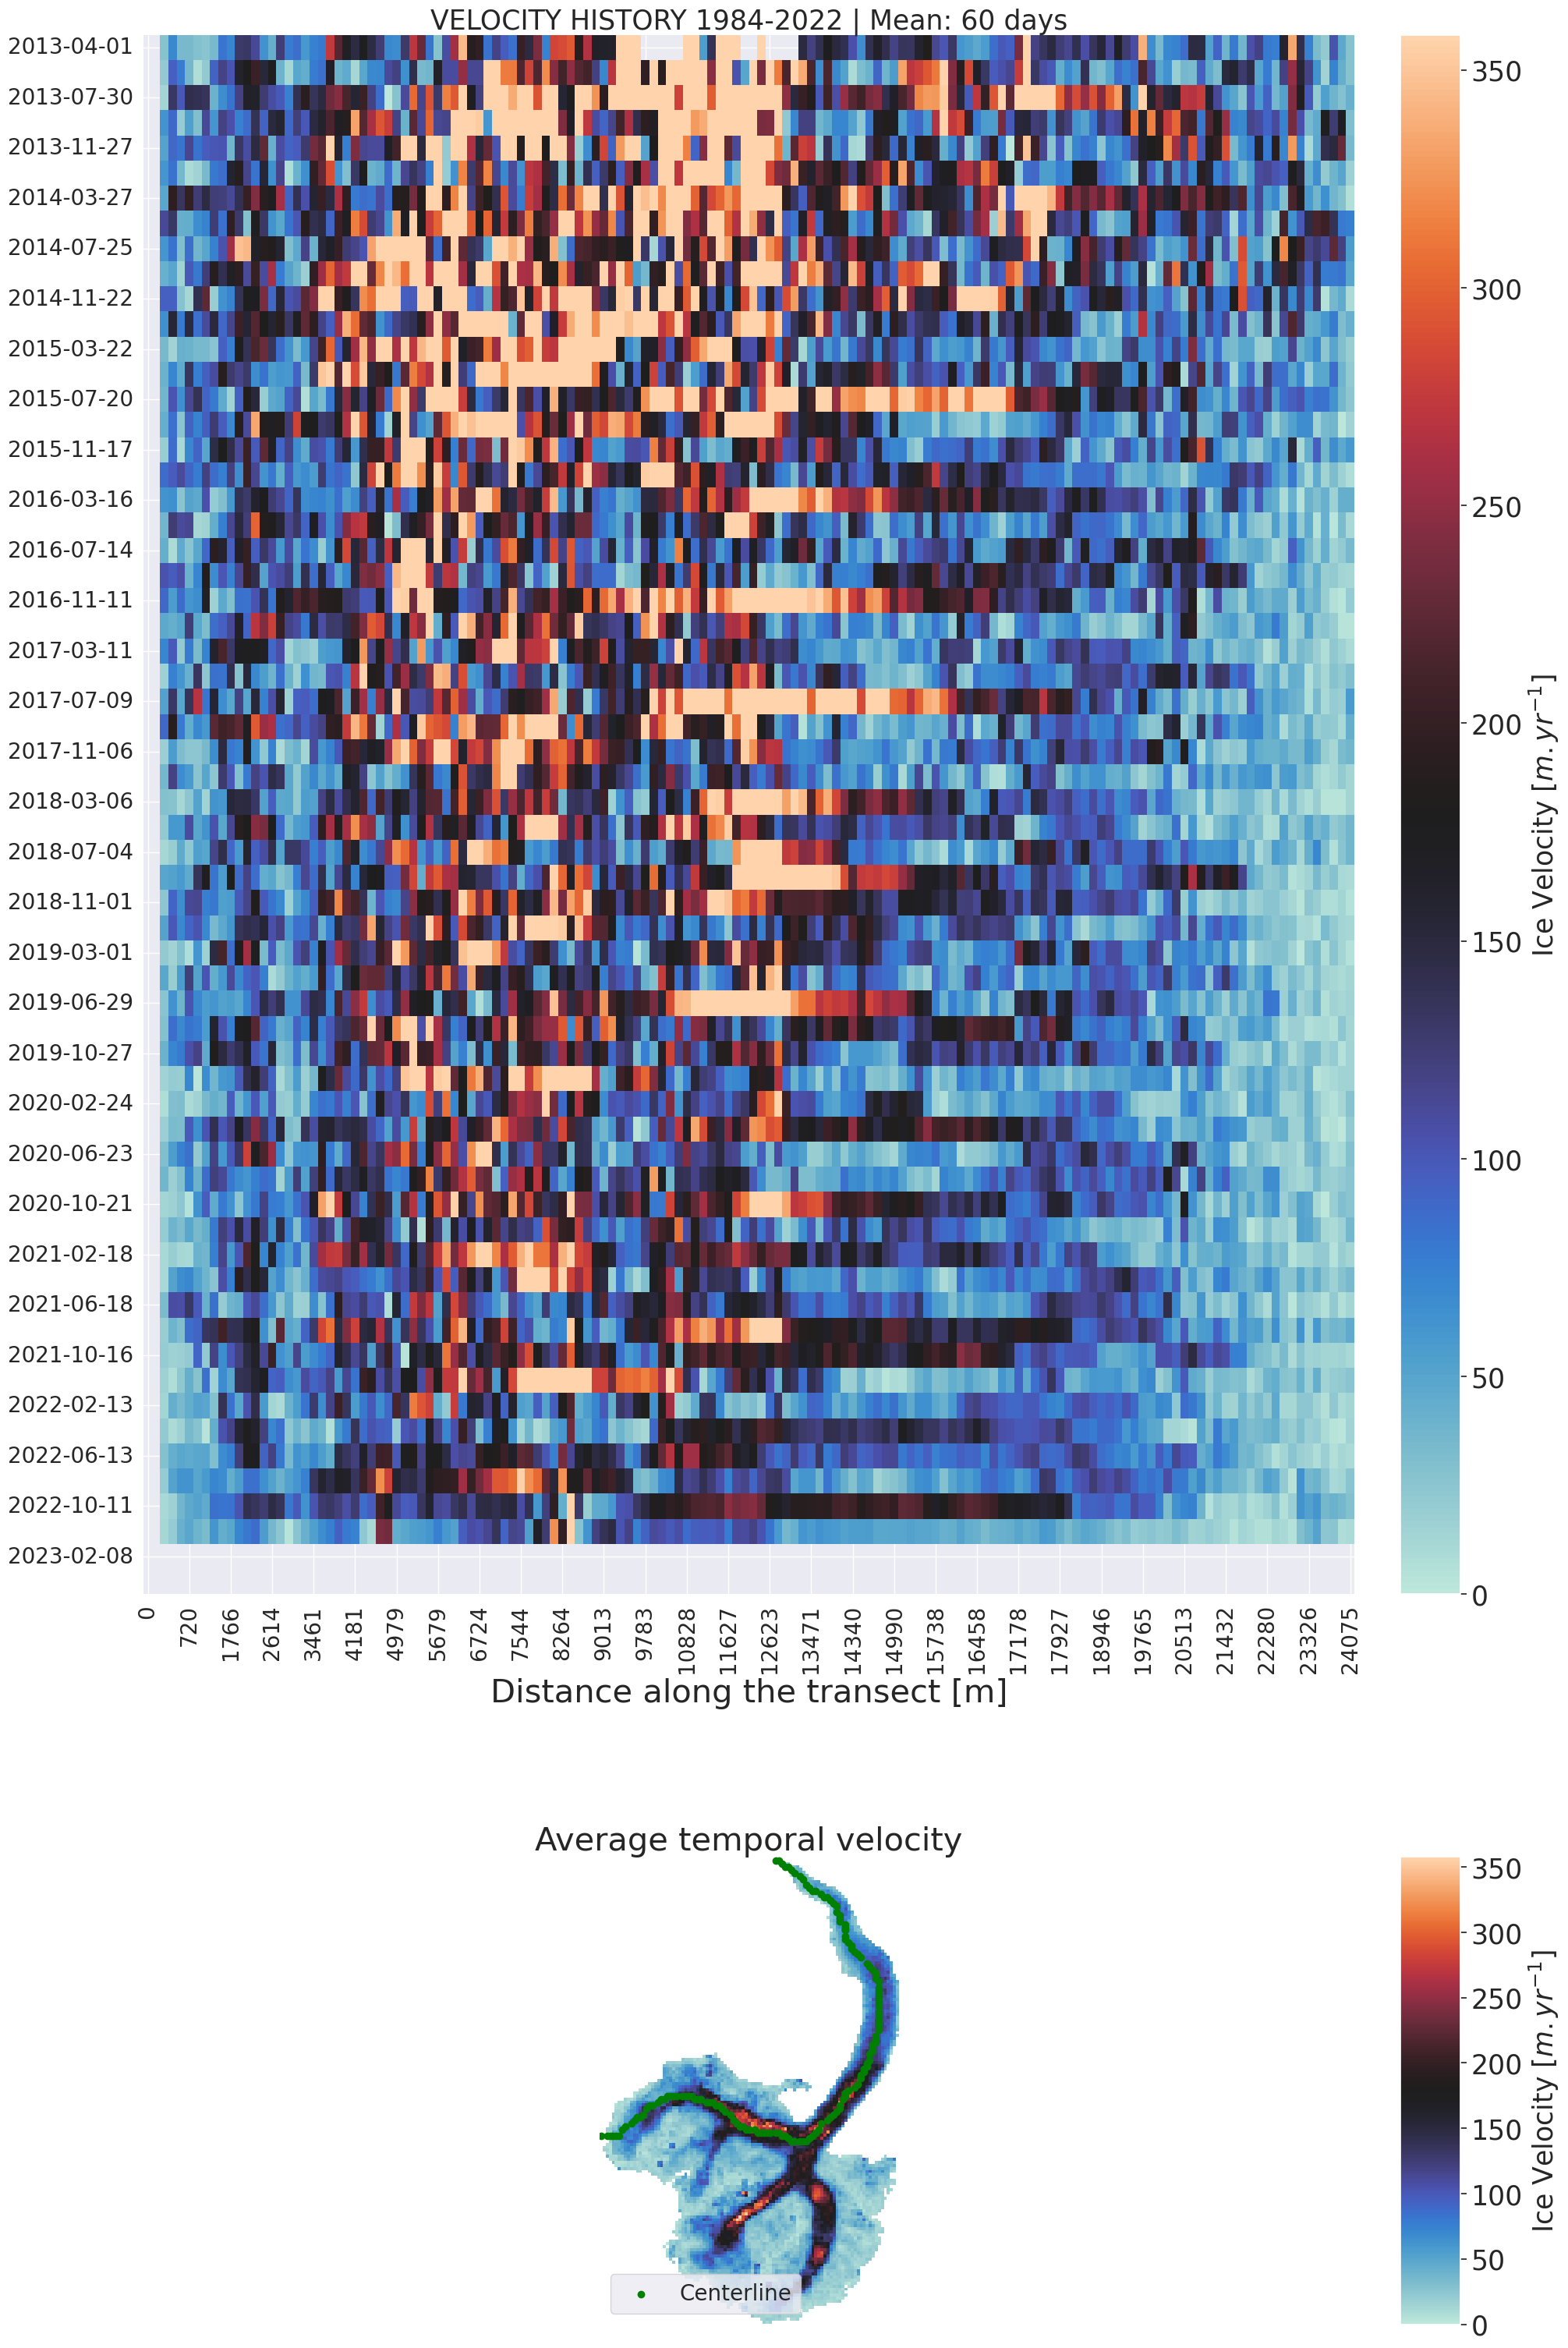

In [8]:
# We take the 75% quantile as the maximum velocity color
vmax = np.nanquantile(avg_vels, q = 1)

# Figure size
fsize = 25

# Initialize figure with custom height ratios
f, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw={'height_ratios': [20, 6], 'width_ratios': [1, 0.05],'wspace': 0.05, 'hspace': 0.1}, figsize=(20, 30), constrained_layout=True)

# Reduce vertical spacing (hspace) and horizontal spacing (wspace)
f.subplots_adjust(hspace=0.05, wspace=0.05)
sns.set(font_scale=3)

# plot velocity profile
heatmap = sns.heatmap(df, cmap='icefire', ax=ax[0, 0], vmin=0, vmax=vmax, cbar=None)
# Set y-axis ticks and labels
# In this example, I'm using every 12th data point from the DataFrame index
# to set the y-ticks and month_labels to reduce clutter on the y-axis.
# You can adjust the frequency of ticks and labels based on your specific dataset.

#ax[0,0].yaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
ax[0,0].xaxis.set_minor_locator(mdates.MonthLocator())
# We change the fontsize of minor ticks label
ax[0, 0].tick_params(axis='both', which='major', labelsize=20)
ax[0, 0].tick_params(axis='both', which='minor', labelsize=20)
ax[0, 0].set_xlabel('Distance along the transect [m]', fontsize = 30)

# Create the colorbar subplot in the 2nd column
cbar = plt.colorbar(heatmap.collections[0], cax=ax[0, 1], pad=0.1)
cbar.ax.tick_params(labelsize=fsize)
cbar.ax.set_ylabel("Ice Velocity [$m.yr^{-1}$]", fontsize=fsize)

# Create the colorbar subplot in the 2nd column
cbar = plt.colorbar(heatmap.collections[0], cax=ax[1, 1], pad=0.1)
cbar.ax.tick_params(labelsize=fsize)
cbar.ax.set_ylabel("Ice Velocity [$m.yr^{-1}$]", fontsize=fsize)

# plot a spatial representation of the three tributaries
ax[1, 0].imshow(avg_vels, vmax=vmax, cmap='icefire')
ax[1, 0].scatter(glacier.x_coords_centerline, glacier.y_coords_centerline, color = 'green', label = 'Centerline')
ax[1, 0].legend(fontsize = 20)
ax[1, 0].axis('off')  # Remove ticks and labels
ax[1, 0].set_title('Average temporal velocity', fontsize = 30)

ax[0, 0].set_title(f"VELOCITY HISTORY 1984-2022 | Mean: {60} {'days'}", fontsize=fsize)


f.show()
f.set_facecolor('white') 

f.savefig('./figs/Hovmoller.png')

#### Group the data by year

In [10]:
# Group by year and calculate the mean
mean_da = da.groupby('time.year').mean('time', skipna=True)

# Quick example of how to plot it
plt.imshow(mean_da[3])